__Loading dependencies__

In [1]:
import pandas as pd
import numpy as np
import types
from botocore.client import Config
import ibm_boto3
import requests
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
import matplotlib.pyplot as plt

In [2]:
def __iter__(self): return 0

In [3]:
# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_ab10326247bc4b83919a609ccd5bf886 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='rEyAiWMm-r26LRfEWL2GQ0c5_DU2ZPbaDOtFjvQ2TeMV',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_ab10326247bc4b83919a609ccd5bf886.get_object(Bucket='applieddatasciencecapstonenoteboo-donotdelete-pr-iathmibdymdeqm',Key='AB_US_2020.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_ab = pd.read_csv(body)
df_ab.head()


/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,city
0,38585,Charming Victorian home - twin beds + breakfast,165529,Evelyne,NaN,28804,35.65146,-82.62792,Private room,60,1,138,16/02/20,1.14,1,0,Asheville
1,80905,French Chic Loft,427027,Celeste,NaN,28801,35.59779,-82.55540,Entire home/apt,470,1,114,07/09/20,1.03,11,288,Asheville
2,108061,Walk to stores/parks/downtown. Fenced yard/Pet...,320564,Lisa,NaN,28801,35.60670,-82.55563,Entire home/apt,75,30,89,30/11/19,0.81,2,298,Asheville
3,155305,Cottage! BonPaul + Sharky's Hostel,746673,BonPaul,NaN,28806,35.57864,-82.59578,Entire home/apt,90,1,267,22/09/20,2.39,5,0,Asheville
4,160594,Historic Grove Park,769252,Elizabeth,NaN,28801,35.61442,-82.54127,Private room,125,30,58,19/10/15,0.52,1,0,Asheville


__In order to fit it under the Foursquare API call limit,__<br>
__The data set is filtered to include Airbnbs that are:__<br>
__1. Full, studio apartments__<br>
__2. Located in NYC__<br>
__3. Do not require a lease of more than 30 days__<br>
__4. Have at least 3 reviews__

In [4]:
df_ab = df_ab[df_ab["city"]== "New York City"]
df_ab = df_ab[df_ab["room_type"] == "Entire home/apt"]
df_ab = df_ab[df_ab["minimum_nights"] <= 30]
df_ab = df_ab[df_ab["number_of_reviews"] >= 3]
df_ab = df_ab[df_ab["name"].astype(str).str.contains("studio")]
df_ab

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,city
117165,6848,Only 2 stops to Manhattan studio,15991,Allen & Irina,Brooklyn,Williamsburg,40.70837,-73.95352,Entire home/apt,109,2,181,16/03/20,1.32,1,0,New York City
117250,28907,Garden studio in the Upper East Sid,124352,Lisa,Manhattan,Upper East Side,40.77800,-73.94822,Entire home/apt,150,5,21,15/08/17,0.17,1,246,New York City
117294,44288,CO-VID IMMUNE! Entire studio in West Village,193637,Sara,Manhattan,West Village,40.73756,-74.00405,Entire home/apt,128,3,90,15/06/20,0.74,1,278,New York City
117312,53469,cozy studio with parking spot,204539,Mark,Queens,Middle Village,40.71722,-73.87856,Entire home/apt,100,7,33,09/05/15,0.27,6,365,New York City
117362,62903,Beautiful modern studio apartment in heart of NYC,306605,Daniel,Manhattan,Chelsea,40.74238,-73.99567,Entire home/apt,205,15,68,14/12/19,0.66,2,89,New York City
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159769,43068232,Cozy studio in Mott Haven with Victorian charm,55164,Kiri And Rob,Bronx,Port Morris,40.80535,-73.92294,Entire home/apt,45,2,3,25/08/20,0.62,1,37,New York City
159976,43163186,Artistic and clean studio near Union Square,6384454,Ella,Manhattan,East Village,40.73176,-73.98617,Entire home/apt,160,4,5,30/08/20,1.47,1,24,New York City
160613,43527094,Cozy studio apartment,185029671,Kat,Bronx,Kingsbridge,40.87208,-73.90239,Entire home/apt,131,1,10,02/08/20,3.66,2,88,New York City
161322,44015851,Chelsea studio in the heart of Manhattan,108164496,Natasha,Manhattan,Chelsea,40.74405,-73.99712,Entire home/apt,110,13,3,17/08/20,1.96,1,35,New York City


In [5]:
df_nyc = df_ab[["name", "neighbourhood_group", "neighbourhood", "latitude", "longitude", "price"]]
df_nyc.reset_index(inplace = True)
df_nyc

,index,name,neighbourhood_group,neighbourhood,latitude,longitude,price
0,117165,Only 2 stops to Manhattan studio,Brooklyn,Williamsburg,40.70837,-73.95352,109
1,117250,Garden studio in the Upper East Sid,Manhattan,Upper East Side,40.77800,-73.94822,150
2,117294,CO-VID IMMUNE! Entire studio in West Village,Manhattan,West Village,40.73756,-74.00405,128
3,117312,cozy studio with parking spot,Queens,Middle Village,40.71722,-73.87856,100
4,117362,Beautiful modern studio apartment in heart of NYC,Manhattan,Chelsea,40.74238,-73.99567,205
...,...,...,...,...,...,...,...
523,159769,Cozy studio in Mott Haven with Victorian charm,Bronx,Port Morris,40.80535,-73.92294,45
524,159976,Artistic and clean studio near Union Square,Manhattan,East Village,40.73176,-73.98617,160
525,160613,Cozy studio apartment,Bronx,Kingsbridge,40.87208,-73.90239,131
526,161322,Chelsea studio in the heart of Manhattan,Manhattan,Chelsea,40.74405,-73.99712,110


__Examining outliers__

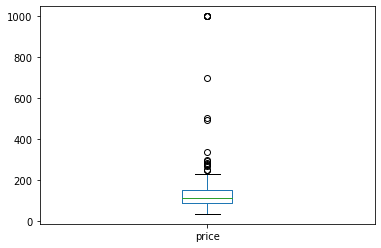

In [6]:
df_nyc["price"].plot(kind = "box")

In [7]:
df_nyc.sort_values(by = "price", ascending = False).head(15)

,index,name,neighbourhood_group,neighbourhood,latitude,longitude,price
349,144109,Nicely lit UWS studio apartment,Manhattan,Upper West Side,40.80188,-73.96923,1000
514,157935,Cozy studio next to Empire State,Manhattan,Midtown,40.74781,-73.98900,999
512,157865,Empire state studio 5,Manhattan,Midtown,40.74767,-73.98670,999
516,158195,Central manhattan bunkbeds studio,Manhattan,Midtown,40.74747,-73.98757,999
517,158198,Cute studio at central midtown manhattan,Manhattan,Midtown,40.74784,-73.98731,999
362,145094,Large quiet private studio in East Harlem,Manhattan,East Harlem,40.80141,-73.93814,700
16,118153,Great studio apt in midtown west!,Manhattan,Chelsea,40.75086,-73.99776,502
473,153727,Cozy sized studio in great kew gardens area,Queens,Kew Gardens,40.70682,-73.83143,493
86,123654,The Manhattan Club studio New York,Manhattan,Midtown,40.76365,-73.98057,336
404,147996,Private Gramercy studio btwn downtown & midtown!,Manhattan,Gramercy,40.73572,-73.98017,298


In [8]:
# @hidden_cell

CLIENT_ID = "HIRTIRTHWLFDGRF0B5OSXBUBE4SHUHJC11OK24BLKA1AGSZO"
CLIENT_SECRET = "0JK1F0NXDSN4W5ZGAWUSOFJ2ETPH2ZRIDU3W4ODHBQCVBRFX"
VERSION = "20180605"
LIMIT = 100

__Defining a function that gets nearby venues around a given Airbnb__

In [9]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    venue_list = []
    for name, latitude, longitude in zip(names, latitudes, longitudes):
        
        url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(
            CLIENT_ID,
            CLIENT_SECRET,
            latitude,
            longitude,
            VERSION,
            radius,
            LIMIT)
        
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        venue_list.append([(
        name,
        latitude,
        longitude,
        r["venue"]["name"],
        r["venue"]["location"]["lat"],
        r["venue"]["location"]["lng"],
        r["venue"]["categories"][0]["name"]) for r in results])
        
        nearby_venues = pd.DataFrame([item for venue in venue_list for item in venue])
        nearby_venues.columns = ['Listing Name', 
                  'Apartment Latitude', 
                  'Apartment Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [10]:
apartment_venues = getNearbyVenues(names = df_nyc["name"],
                                 latitudes = df_nyc['latitude'],
                                 longitudes = df_nyc['longitude'])
apartment_venues

,Listing Name,Apartment Latitude,Apartment Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Only 2 stops to Manhattan studio,40.70837,-73.95352,The Flat's BK Speed Coffee,40.707304,-73.953867,Coffee Shop
1,Only 2 stops to Manhattan studio,40.70837,-73.95352,Bar Velo Brooklyn,40.707097,-73.954332,Wine Bar
2,Only 2 stops to Manhattan studio,40.70837,-73.95352,Mexico 2000,40.707552,-73.955052,Taco Place
3,Only 2 stops to Manhattan studio,40.70837,-73.95352,Williamsburg Pizza,40.708303,-73.950699,Pizza Place
4,Only 2 stops to Manhattan studio,40.70837,-73.95352,Dough Vale,40.709306,-73.954056,Italian Restaurant
...,...,...,...,...,...,...,...
38345,"Cozy studio - 20mins to Times Sq, close to LGA",40.75984,-73.91272,Al's Italian Pizzaria & Restaurant,40.757482,-73.908939,Middle Eastern Restaurant
38346,"Cozy studio - 20mins to Times Sq, close to LGA",40.75984,-73.91272,"Broadway Fish Market, inc",40.755905,-73.912421,Fish Market
38347,"Cozy studio - 20mins to Times Sq, close to LGA",40.75984,-73.91272,Yummy Taco,40.755604,-73.912285,Taco Place
38348,"Cozy studio - 20mins to Times Sq, close to LGA",40.75984,-73.91272,Globe Coffee Shop & Restaurant,40.757471,-73.907727,Coffee Shop


__One-hot encoding__

In [59]:
venues_onehot = pd.get_dummies(apartment_venues["Venue Category"])
venues_onehot["Listing Name"] = apartment_venues["Listing Name"]

__Grouping venues by Airbnb, and obtaining normalized values for each Airbnb__

In [60]:
venues_grouped = venues_onehot.groupby("Listing Name").mean().reset_index()
venues_grouped

,Listing Name,Accessories Store,Acupuncturist,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Amphitheater,Animal Shelter,...,Vietnamese Restaurant,Volleyball Court,Warehouse Store,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,"#4 Cozy studio, 2 blocks from CENTRAL PARK",0.000000,0.0,0.0,0.0,0.0,0.0,0.010638,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.00,0.021277,0.000000,0.0,0.00
1,"1 Bedroom studio 15Mins from JFK,30 mins by ca...",0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.00,0.000000,0.000000,0.0,0.00
2,1 bdrm/large studio in a great location,0.000000,0.0,0.0,0.0,0.0,0.0,0.010989,0.0,0.0,...,0.010989,0.0,0.0,0.0,0.010989,0.00,0.032967,0.010989,0.0,0.00
3,1B Large studio in Williamsburg with terrace,0.012195,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.012195,0.00,0.012195,0.000000,0.0,0.00
4,1st flr full studio apartment- entire place/SAFE,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.00,0.000000,0.000000,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
521,studio in the Kut Kave,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.00,0.000000,0.000000,0.0,0.00
522,studio in the bronx\n25 minute to times square...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.00,0.000000,0.018868,0.0,0.00
523,the Perfect LES studio,0.000000,0.0,0.0,0.0,0.0,0.0,0.010000,0.0,0.0,...,0.030000,0.0,0.0,0.0,0.010000,0.02,0.030000,0.000000,0.0,0.02
524,·É¶ Spacious and chill studio ÏõÉ‚ô•Ïú†,0.000000,0.0,0.0,0.0,0.0,0.0,0.022727,0.0,0.0,...,0.022727,0.0,0.0,0.0,0.000000,0.00,0.000000,0.000000,0.0,0.00


In [61]:
model_df = venues_grouped.merge(df_nyc, left_on = "Listing Name", right_on = "name")
model_df = model_df.reset_index()
model_df = model_df.drop(columns = ["Listing Name", "name", "neighbourhood_group", "neighbourhood", "latitude", "longitude", "index", "level_0"])
model_df

,Accessories Store,Acupuncturist,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,...,Volleyball Court,Warehouse Store,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,price
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.010638,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.00,0.021277,0.000000,0.0,0.00,150
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.00,0.000000,0.000000,0.0,0.00,80
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.010989,0.0,0.0,0.0,...,0.0,0.0,0.0,0.010989,0.00,0.032967,0.010989,0.0,0.00,99
3,0.012195,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.012195,0.00,0.012195,0.000000,0.0,0.00,85
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.00,0.000000,0.000000,0.0,0.00,91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
523,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.00,0.000000,0.000000,0.0,0.00,112
524,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.00,0.000000,0.018868,0.0,0.00,56
525,0.000000,0.0,0.0,0.0,0.0,0.0,0.010000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.010000,0.02,0.030000,0.000000,0.0,0.02,119
526,0.000000,0.0,0.0,0.0,0.0,0.0,0.022727,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.00,0.000000,0.000000,0.0,0.00,98


__Separating data into independent and dependent variables__

In [116]:
x = model_df.iloc[:,:449]
y = model_df.iloc[:,449].to_frame()

__Splitting training and testing data__

In [125]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.1,random_state=8)

__Implementing GridSearch to find the best hyperparameters for GradientBoostingRegressor__

In [132]:
from sklearn.model_selection import GridSearchCV
gb = GradientBoostingRegressor()
parameters = [{"learning_rate":[0.01,0.1,0.3], "n_estimators":[10,100,1000]}]
GridSearch = GridSearchCV(gb, parameters, cv = 5)
GridSearch.fit(x_train,y_train)

GridSearch.best_estimator_

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

GradientBoostingRegressor(learning_rate=0.01, n_estimators=10)

__Model 1. GradientBoostingRegressor__

In [128]:
gb = GradientBoostingRegressor(learning_rate = 0.01, n_estimators = 1000)
gb.fit(x_train,y_train)
gb_yhat = gb.predict(x_test)

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


__Model 2. DecisionTreeRegressor__

In [126]:
dt = DecisionTreeRegressor()
dt.fit(x_train,y_train)
dt_yhat = dt.predict(x_test)

__Comparing actual values with predicted values__

In [127]:
df_prices = pd.DataFrame(columns = ["actual","gbr_predicted","dtr_predicted"])
df_prices["actual"] = y_test["price"]
df_prices["gbr_predicted"] = gb_yhat
df_prices["dtr_predicted"] = dt_yhat
df_prices.head(10)

,actual,gbr_predicted,dtr_predicted
455,83,79.579298,130.0
131,120,145.568716,165.0
235,70,115.815695,80.0
25,175,120.379094,115.0
127,70,138.744851,100.0
497,200,68.239596,155.0
487,86,122.656207,124.0
474,115,83.705346,100.0
8,135,128.058924,101.0
507,135,124.161025,100.0


__Model Evaluation__

In [129]:
gb_mse = mean_squared_error(gb_yhat, y_test)
gb_r2 = r2_score(gb_yhat, y_test)

print("Mean Squared Error for GradientBoostingRegressor: {:0.2f}".format(gb_mse))
print("R2 Score for GradientBoostingRegressor: {:0.2f}".format(gb_r2))

Mean Squared Error for GradientBoostingRegressor: 1619.56
R2 Score for GradientBoostingRegressor: 0.85


In [130]:
dt_mse = mean_squared_error(dt_yhat, y_test)
dt_r2 = r2_score(dt_yhat, y_test)

print("Mean Squared Error for DecisionTreeRegressor: {:0.2f}".format(dt_mse))
print("R2 Score for DecisionTreeRegressor: {:0.2f}".format(dt_r2))

Mean Squared Error for DecisionTreeRegressor: 2135.13
R2 Score for DecisionTreeRegressor: 0.86
